<a href="https://colab.research.google.com/github/cyndwith/DeepGC/blob/master/SRCNN/mySRCNN_9_5_5_rev2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [0]:
%tensorflow_version 2.x

In [0]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds


/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Shuffling and writing examples to /root/tensorflow_datasets/oxford_flowers102/2.0.0.incomplete6VX2C4/oxford_flowers102-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/oxford_flowers102/2.0.0.incomplete6VX2C4/oxford_flowers102-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/oxford_flowers102/2.0.0.incomplete6VX2C4/oxford_flowers102-validation.tfrecord



Dataset oxford_flowers102 downloaded and prepared to /root/tensorflow_datasets/oxford_flowers102/2.0.0. Subsequent calls will reuse this data.
tfds.core.DatasetInfo(
    name='oxford_flowers102',
    version=2.0.0,
    description='
The Oxford Flowers 102 dataset is a consistent of 102 flower categories commonly occurring
in the United Kingdom. Each class consists of between 40 and 258 images. The images have
large scale, pose and light variations. In addition, there are categories that have large
variations within the category and several very similar categories.

The dataset is divided into a training set, a validation set and a test set.
The training set and validation set each consist of 10 images per class (totalling 1020 images each).
The test set consists of the remaining 6149 images (minimum 20 per class).
',
    homepage='https://www.robots.ox.ac.uk/~vgg/data/flowers/102/',
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=tf.string),
        'image': Imag

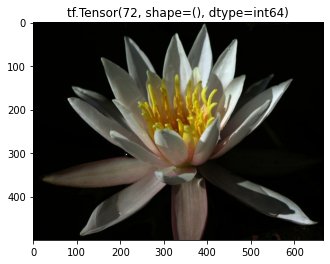

In [4]:
splits = ("train[:80]", "train[:10]", "train[:10]")
#splits = tfds.Split.TRAIN.subsplit(weighted=SPLIT_WEIGHTS)

(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'oxford_flowers102', split=splits,
    with_info=True, as_supervised=True)

print(metadata)
print(raw_train)
print(raw_validation)
print(raw_test)

get_label_name = metadata.features['label'].int2str
for image, label in raw_train.take(1):
  plt.figure()
  plt.imshow(image)
  plt.title(get_label_name(label))


<DatasetV1Adapter shapes: ((None, None, 1), ()), types: (tf.float32, tf.int64)>
<DatasetV1Adapter shapes: ((None, None, 1), ()), types: (tf.float32, tf.int64)>
<DatasetV1Adapter shapes: ((None, None, 1), ()), types: (tf.float32, tf.int64)>


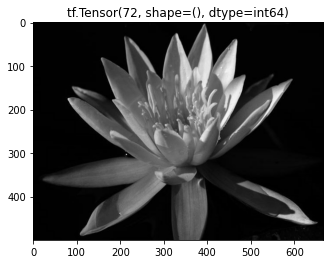

In [5]:
def resize_dataset(image, label):
  image = tf.image.rgb_to_grayscale(image)
  image = tf.cast(image, tf.float32)
  image = (image/255)
  #image = tf.image.resize(image, (128, 128))
  return image, label 

# Apply this function to each item in the dataset using the map method:
flower_train      = raw_train.map(resize_dataset)
flower_validation = raw_validation.map(resize_dataset)
flower_test       = raw_test.map(resize_dataset)
print(flower_train)
print(flower_validation)
print(flower_test)

for image, label in flower_train.take(1):
  plt.figure()
  plt.imshow(tf.squeeze(image), cmap='gray')
  plt.title(get_label_name(label))

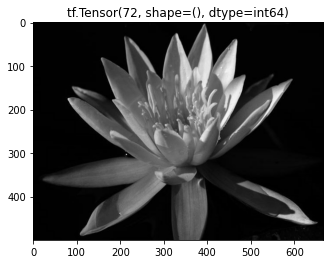

In [6]:
# Format the Data
SCALE = 3
STRIDE = 14
IMG_SIZE = 33 # All images will be divided into 33x33 patch
LABEL_SIZE = 21
def format_dataset(dataset):
  count = 0
  sub_input_sequence = []
  sub_label_sequence = []
  for image, label in dataset:
    #print('image.shape', image.shape)
    if (len(image.shape) == 3):
      image = tf.expand_dims(image, axis=0)
    #print('image.shape', image.shape)
    _, h, w, _ = image.shape
    #print('before (h,w):', h, w)
    h = h - np.mod(h, SCALE)
    w = w - np.mod(w, SCALE)
    #print('after (h,w"):', h, w)

    image = np.array(image).astype(np.float)
    label = image[0, 0:h, 0:w, :]
    #print('label:', label.shape)
    
    image = image / 255.
    label = label / 255.

    down_size = (int(h/SCALE), int(w/SCALE))
    up_size = (h, w)
    
    input_resize = tf.image.resize(label, down_size)
    input_resize = tf.image.resize(input_resize, up_size)
    pad = abs(IMG_SIZE - LABEL_SIZE) / 2
    for y in range(0, h - IMG_SIZE+1, STRIDE):
      for x in range(0, w - IMG_SIZE+1, STRIDE):
        sub_input = input_resize[y:y+IMG_SIZE, x:x+IMG_SIZE, :]
        sub_label = label[y+int(pad):y+int(pad)+LABEL_SIZE, x+int(pad):x+int(pad)+LABEL_SIZE, :]
        
        sub_input = tf.reshape(sub_input, [IMG_SIZE, IMG_SIZE, 1])
        sub_label = tf.reshape(sub_label, [LABEL_SIZE, LABEL_SIZE, 1])
        
        sub_input_sequence.append(sub_input)
        sub_label_sequence.append(sub_label)
        
    count += 1
    print("image count:", count)      
    # if (count == 50):
    #   break

  # sub_input_sequence = np.asarray(sub_input_sequence).astype(np.float32)
  # sub_label_sequence = np.asarray(sub_label_sequence).astype(np.float32)

  dataset = tf.data.Dataset.from_tensor_slices((sub_input_sequence, sub_label_sequence))
  # return sub_input_sequence, sub_label_sequence
  return dataset

for image, label in flower_train.take(1):
  plt.figure()
  plt.imshow(tf.squeeze(image), cmap='gray')
  plt.title(get_label_name(label))


In [7]:
flower_train_data      = format_dataset(flower_train)
print(flower_train_data)
print('No. images :', len(list(flower_train_data)))

image count: 1
image count: 2
image count: 3
image count: 4
image count: 5
image count: 6
image count: 7
image count: 8
image count: 9
image count: 10
image count: 11
image count: 12
image count: 13
image count: 14
image count: 15
image count: 16
image count: 17
image count: 18
image count: 19
image count: 20
image count: 21
image count: 22
image count: 23
image count: 24
image count: 25
image count: 26
image count: 27
image count: 28
image count: 29
image count: 30
image count: 31
image count: 32
image count: 33
image count: 34
image count: 35
image count: 36
image count: 37
image count: 38
image count: 39
image count: 40
image count: 41
image count: 42
image count: 43
image count: 44
image count: 45
image count: 46
image count: 47
image count: 48
image count: 49
image count: 50
image count: 51
image count: 52
image count: 53
image count: 54
image count: 55
image count: 56
image count: 57
image count: 58
image count: 59
image count: 60
image count: 61
image count: 62
image count: 63
i

In [8]:
flower_validation_data = format_dataset(flower_validation)
print(flower_validation_data)
print('No. images :', len(list(flower_validation_data)))

image count: 1
image count: 2
image count: 3
image count: 4
image count: 5
image count: 6
image count: 7
image count: 8
image count: 9
image count: 10
<TensorSliceDataset shapes: ((33, 33, 1), (21, 21, 1)), types: (tf.float32, tf.float64)>
No. images : 15300


In [9]:
flower_test_data       = format_dataset(flower_test)
print(flower_test_data)
print('No. images :', len(list(flower_test_data)))

image count: 1
image count: 2
image count: 3
image count: 4
image count: 5
image count: 6
image count: 7
image count: 8
image count: 9
image count: 10
<TensorSliceDataset shapes: ((33, 33, 1), (21, 21, 1)), types: (tf.float32, tf.float64)>
No. images : 15300


In [10]:
# Now shuffle and batch the data.

BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 1000

flower_train_batches      = flower_train_data.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
flower_validation_batches = flower_validation_data.batch(BATCH_SIZE, drop_remainder=True)
flower_test_batches       = flower_test_data.batch(BATCH_SIZE, drop_remainder=True)

print(flower_train_batches)
print(flower_validation_batches)
print(flower_test_batches)


<BatchDataset shapes: ((64, 33, 33, 1), (64, 21, 21, 1)), types: (tf.float32, tf.float64)>
<BatchDataset shapes: ((64, 33, 33, 1), (64, 21, 21, 1)), types: (tf.float32, tf.float64)>
<BatchDataset shapes: ((64, 33, 33, 1), (64, 21, 21, 1)), types: (tf.float32, tf.float64)>


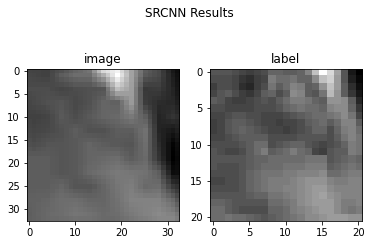

In [11]:
from IPython.display import clear_output

for image, label in flower_train_batches.take(1):
  print('image:', image.shape)
  print('label:', label.shape)
  clear_output()
  fig, (ax1, ax2) = plt.subplots(1, 2)
  fig.suptitle('SRCNN Results')
  ax1.imshow(tf.squeeze(image[1,:, :, :]), cmap='gray')
  ax1.set_title('image')
  ax2.imshow(tf.squeeze(label[1,:, :, :]), cmap='gray')
  ax2.set_title('label')
  plt.pause(0.1)


In [55]:
def merge(images, size):
  h, w = images.shape[1], images.shape[2]
  out_h = (size[0] - 1) * LABEL_SIZE + h
  out_w = (size[1] - 1) * LABEL_SIZE + w
  img = np.zeros((out_h, out_w, 1))
  for idx, image in enumerate(images):
    i = idx % size[1]
    j = idx // size[1]
    #img[j*h:j*h+h, i*w:i*w+w, :] = image
    img[j*LABEL_SIZE:j*LABEL_SIZE+h, i*LABEL_SIZE:i*LABEL_SIZE+w, :] = image

  return img

def test(model, image):
  print('image:', image.shape)
  h, w, _ = image.shape
  nx = ny = 0 
  sub_input = []
  for x in range(0, h - IMG_SIZE+1, LABEL_SIZE):
    nx += 1; ny = 0
    for y in range(0, w - IMG_SIZE+1, LABEL_SIZE):
      ny += 1
      sub_input_patch = image[x:x+IMG_SIZE, y:y+IMG_SIZE, :]    
      sub_input_patch = tf.reshape(sub_input_patch, [IMG_SIZE, IMG_SIZE, 1])
      sub_input.append(sub_input_patch)
  sub_input = np.asarray(sub_input)
  print('sub input shape:', sub_input.shape)
  print('nx,ny:', nx, ny)
  pred = model(sub_input)
  output = merge(pred, [nx, ny])
  return output

def SRCNN955(input_shape):
  n0 = tf.keras.layers.Input(input_shape)
  # conv2d
  n = tf.keras.layers.Conv2D(64, kernel_size=(9, 9), strides=1, padding='valid')(n0)
  n = tf.keras.layers.Conv2D(32, kernel_size=(5, 5), strides=1, padding='same')(n)
  n = tf.keras.layers.Conv2D(1, kernel_size=(5, 5), strides= 1, padding='valid')(n)

  model = tf.keras.Model(inputs=n0, outputs=n, name='srcnn955')
  model.summary()
  return model

input_shape = (IMG_SIZE, IMG_SIZE, 1)
srcnn_model = SRCNN955(input_shape)

Model: "srcnn955"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 33, 33, 1)]       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 25, 25, 64)        5248      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 25, 25, 32)        51232     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 21, 21, 1)         801       
Total params: 57,281
Trainable params: 57,281
Non-trainable params: 0
_________________________________________________________________


In [0]:
import os
import time
from IPython.display import clear_output

def model_loss(pred, ref):
  pred = tf.cast(pred, dtype = tf.float32)
  ref = tf.cast(ref, dtype=tf.float32)
  loss = tf.reduce_mean(tf.square(tf.subtract(pred, ref)))
  return loss

model_optimizer = tf.keras.optimizers.Adam(1e-4)

srcnn_model.compile(optimizer=model_optimizer,
              loss=model_loss,
              metrics=['mse'])

# inception_resnet_v1_model = InceptionResNetV1()
checkpoint_dir = '/content/srcnn_checkpoints/'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=model_optimizer,
                                 model=srcnn_model)

# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(image, ref):
    with tf.GradientTape() as grad_tape:
      pred = srcnn_model(image)
      loss = model_loss(pred, ref)
    gradients_of_model = grad_tape.gradient(loss, srcnn_model.trainable_variables)
    model_optimizer.apply_gradients(zip(gradients_of_model, srcnn_model.trainable_variables))
    print('Training Loss: {}'.format(loss))
    return loss

model_save_path = '/content/srcnn_model/'
def train(dataset, epochs):
  train_history = []
  for epoch in range(epochs):
    start = time.time()
    loss = 0
    for image, label in dataset:
      loss = train_step(image, label)
      #train_history.append(loss)
    # Save the model every 15 epochs
    if (epoch + 1) % 100 == 0:
      srcnn_model.save(model_save_path)
      checkpoint.save(file_prefix = checkpoint_prefix)
      # test after one epoch
      for image, label in flower_train.take(1):
        output = test(srcnn_model, image)
        output = tf.squeeze(output)
        #clear_output()
        '''
        #fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
        fig, axis = plt.subplots(3)
        #fig.suptitle('SRCNN Results')
        axis[0].imshow(tf.squeeze(image[:, :, :]), cmap='gray')
        axis[0].set_title('image')
        h, w, _ = image.shape 
        down_size = [int(h/SCALE), int(w/SCALE)]
        up_size   = [h, w]
        resize_image = tf.image.resize(image, down_size)
        resize_image = tf.image.resize(resize_image, up_size)
        axis[1].imshow(tf.squeeze(resize_image), cmap='gray')
        axis[1].set_title('resize_image')
        axis[2].imshow(tf.squeeze(output), cmap='gray')
        axis[2].set_title('output')
        '''
        clear_output()
        plt.figure(1)
        h, w, _ = image.shape 
        down_size = [int(h/SCALE), int(w/SCALE)]
        up_size   = [h, w]
        resize_image = tf.image.resize(image, down_size)
        resize_image = tf.image.resize(resize_image, up_size)
        plt.imshow(tf.squeeze(resize_image), cmap='gray')
        plt.title('Resize Image (Bilinear)')
        plt.figure(2)
        plt.imshow(tf.squeeze(output), cmap='gray')
        plt.title('output')
        plt.pause(0.1)
    print ('Training Loss {}, Time for epoch {} is {} sec'.format(loss, epoch + 1, time.time()-start))
    train_history.append(loss)
  return train_history

In [46]:
train_history = train(flower_train_batches, 20)
print(train_history)

Training Loss 3.6571967676479744e-09, Time for epoch 1 is 4.22020959854126 sec
Training Loss 4.945999609873297e-09, Time for epoch 2 is 4.219227075576782 sec
Training Loss 4.190444879981214e-09, Time for epoch 3 is 4.192782640457153 sec
Training Loss 3.175684826217662e-09, Time for epoch 4 is 4.170370578765869 sec
Training Loss 2.9901627840445144e-09, Time for epoch 5 is 4.241983652114868 sec
Training Loss 3.322436770147874e-09, Time for epoch 6 is 4.18466591835022 sec
Training Loss 3.760927569373962e-09, Time for epoch 7 is 4.166625499725342 sec
Training Loss 3.658755298729943e-09, Time for epoch 8 is 4.193074941635132 sec
Training Loss 3.983528618078935e-09, Time for epoch 9 is 4.15701150894165 sec
Training Loss 2.841977098100301e-09, Time for epoch 10 is 4.181512355804443 sec
Training Loss 3.6467617814395226e-09, Time for epoch 11 is 4.167455434799194 sec
Training Loss 3.812849147522002e-09, Time for epoch 12 is 4.193988800048828 sec
Training Loss 4.727155999972865e-09, Time for epo

In [44]:
validation_history = train(flower_validation_batches, 20)
print(validation_history)

Training Loss: Tensor("Mean:0", shape=(), dtype=float32)
Training Loss: Tensor("Mean:0", shape=(), dtype=float32)
Training Loss 4.26053547997185e-09, Time for epoch 1 is 0.7869305610656738 sec
Training Loss 4.259590014044079e-09, Time for epoch 2 is 0.535205602645874 sec
Training Loss 4.260197972172364e-09, Time for epoch 3 is 0.5217297077178955 sec
Training Loss 4.278962517645368e-09, Time for epoch 4 is 0.5307326316833496 sec
Training Loss 4.289881783137162e-09, Time for epoch 5 is 0.5229392051696777 sec
Training Loss 4.267679543090708e-09, Time for epoch 6 is 0.5455620288848877 sec
Training Loss 4.2560874824459916e-09, Time for epoch 7 is 0.5209145545959473 sec
Training Loss 4.253550400790118e-09, Time for epoch 8 is 0.5305972099304199 sec
Training Loss 4.253529972686465e-09, Time for epoch 9 is 0.5217981338500977 sec
Training Loss 4.2539700650934265e-09, Time for epoch 10 is 0.5382113456726074 sec
Training Loss 4.254460339581101e-09, Time for epoch 11 is 0.5237946510314941 sec
Trai

In [45]:
test_history = train(flower_test_batches, 20)
print(test_history)

Training Loss 4.2580130532599014e-09, Time for epoch 1 is 0.5399072170257568 sec
Training Loss 4.258333685669413e-09, Time for epoch 2 is 0.5260064601898193 sec
Training Loss 4.258656982614184e-09, Time for epoch 3 is 0.5227782726287842 sec
Training Loss 4.259008701268385e-09, Time for epoch 4 is 0.525043249130249 sec
Training Loss 4.2593693017067835e-09, Time for epoch 5 is 0.5202250480651855 sec
Training Loss 4.259749886159625e-09, Time for epoch 6 is 0.5254082679748535 sec
Training Loss 4.2601571159650575e-09, Time for epoch 7 is 0.5179862976074219 sec
Training Loss 4.260576780268366e-09, Time for epoch 8 is 0.5211906433105469 sec
Training Loss 4.2610248662811046e-09, Time for epoch 9 is 0.5212159156799316 sec
Training Loss 4.2615115880551e-09, Time for epoch 10 is 0.530714750289917 sec
Training Loss 4.262027175627736e-09, Time for epoch 11 is 0.5198564529418945 sec
Training Loss 4.2625831753184684e-09, Time for epoch 12 is 0.5262458324432373 sec
Training Loss 4.263184916197815e-09,

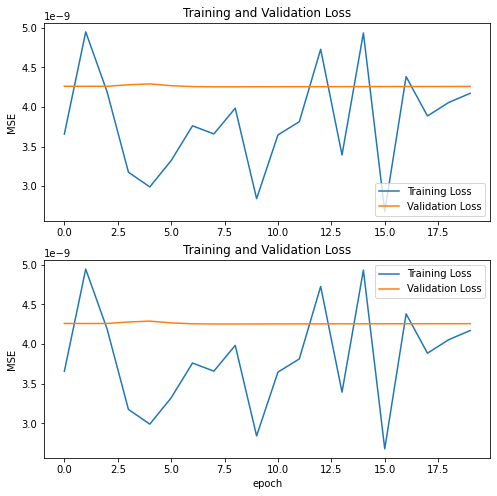

In [47]:
# Learning curves
loss      = train_history
val_loss  = validation_history
test_loss = test_history

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='lower right')
plt.ylabel('MSE')
plt.ylim([min(plt.ylim()),max(plt.ylim())])
plt.title('Training and Validation Loss')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('MSE')
plt.ylim([min(plt.ylim()),max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [0]:
# Evaluate the model

In [49]:
# Convert Keras model to TF Lite format.
print(tf.__version__)
converter = tf.lite.TFLiteConverter.from_keras_model(srcnn_model)
tflite_float_model = converter.convert()

# Show model size in KBs.
float_model_size = len(tflite_float_model) / 1024
print('Float model size = %dKBs.' % float_model_size)

2.2.0-rc2
Float model size = 224KBs.


In [50]:
# Re-convert the model to TF Lite using quantization.
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

# Show model size in KBs.
quantized_model_size = len(tflite_quantized_model) / 1024
print('Quantized model size = %dKBs,' % quantized_model_size)
print('which is about %d%% of the float model size.'\
      % (quantized_model_size * 100 / float_model_size))

Quantized model size = 59KBs,
which is about 26% of the float model size.


In [0]:
import random

test_image = []
for image, label in flower_train.take(1):
  test_images = image

def preprocess(image):
  h, w, _ = image.shape
  nx = ny = 0 
  sub_input = []
  for x in range(0, h - IMG_SIZE+1, LABEL_SIZE):
    nx += 1; ny = 0
    for y in range(0, w - IMG_SIZE+1, LABEL_SIZE):
      ny += 1
      sub_input_patch = image[x:x+IMG_SIZE, y:y+IMG_SIZE, :]    
      sub_input_patch = tf.reshape(sub_input_patch, [IMG_SIZE, IMG_SIZE, 1])
      sub_input.append(sub_input_patch)
  sub_input = np.asarray(sub_input)
  return sub_input, [nx, ny]

def show_model_predictions(tflite_model, dataset=test_images, num=1):
  # Initialize TFLite interpreter using the model.
  interpreter = tf.lite.Interpreter(model_content=tflite_model)
  interpreter.allocate_tensors()
  input_tensor_index = interpreter.get_input_details()[0]["index"]
  inp = interpreter.tensor(interpreter.get_input_details()[0]["index"])
  print(inp)
  output = interpreter.tensor(interpreter.get_output_details()[0]["index"])
  print(output)
  prediction_image = []
  # Run predictions on every image in the "test" dataset.
  for test_image, test_label in flower_train.take(1):
    # Pre-processing: divide image into 33x33 patch
    test_image_batch, [nx, ny] = preprocess(test_image)
    prediction_images = []
    batches = len(test_image_batch[:, 0, 0, 0])
    for i in range(batches):
      image_patch = test_image_batch[i, :, :, :]
      print('image_patch:', image_patch.shape)
      image_patch = tf.expand_dims(image_patch, axis = 0)
      print('image_patch:', image_patch.shape)  
      interpreter.set_tensor(input_tensor_index, image_patch)
      # Run inference.
      interpreter.invoke()
      # Post-processing: merge the predicted 21x21 patch
      prediction_image.append(output())
    print('prediction_image:', prediction_image.shape)
    output = merge(prediction_image, [nx, ny])
    output = tf.squeeze(output)
    clear_output()
    plt.figure(1)
    plt.imshow(tf.squeeze(output), cmap='gray')
    plt.pause(0.1)   


# float model prediction
show_model_predictions(tflite_float_model)

# quantized model prediction
show_model_predictions(tflite_quantized_model)